In [23]:
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Image


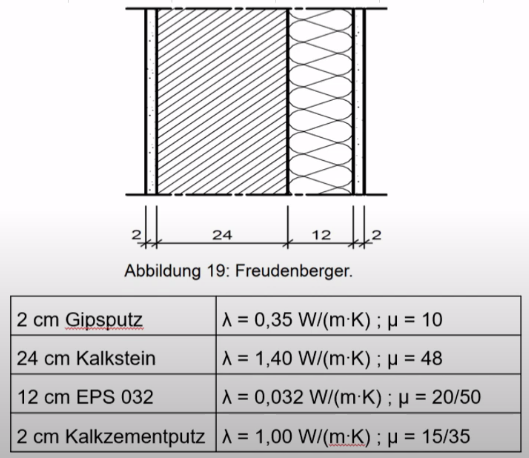

,Material,Thickness,Conductivity,mu
0,Plaster,0.02,0.350,10
1,Fiberglass,0.24,1.400,48
2,EPS32,0.12,0.032,20
3,LimeCementMortar,0.02,1.000,35


In [24]:
layers = pd.DataFrame(columns=["Material", "Thickness", "Conductivity", "mu"])

# Example 1

plaster = ["Plaster", 0.02, 0.35, 10]
fiberglass = ["Fiberglass", 0.24, 1.4, 48]
eps32 = ["EPS32", 0.12, 0.032, 20]
lime_cement_mortar = ["LimeCementMortar", 0.02, 1.0, 35]  #

layers.loc[0] = plaster
layers.loc[1] = fiberglass
layers.loc[2] = eps32
layers.loc[3] = lime_cement_mortar

display(Image("./GlaserMethod_FreudenbergerExample.png"))


######

# Example 2 
# Source: https://www.youtube.com/watch?v=Sf2LtiMgSyc

# drywall = ["Drywall", 0.0125, 0.25, 8]
# fiberglass = ["Fiberglass", 0.1, 0.04, 1]
# concrete = ["Concrete", 0.05, 2.3, 130]  # mu = 80 in best case, 130 in worst case


# layers.loc[0] = drywall
# layers.loc[1] = fiberglass
# layers.loc[2] = concrete

# display(Image("./GlaserMethod_DefaultExample.png"))


###


display(layers)


In [25]:
def calculate_R(row):
    thickness = row["Thickness"]
    conductivity = row["Conductivity"]
    return thickness / conductivity


def calculate_sd(row):
    return row["mu"] * row["Thickness"]


def add_Rsi(df, R_si):
    df.loc[-1] = ["InternalAir", 0, 0, 0, R_si, 0.1]
    df.index = df.index + 1
    df.sort_index(inplace=True)


def add_Rse(df, R_se):
    df.loc[-1] = ["ExternalAir", 0, 0, 0, R_se, 0.1]
    df.index = df.index + 1
    df.reset_index(inplace=True, drop=True)


layers["R"] = layers.apply(calculate_R, axis=1)
layers["sd"] = layers.apply(calculate_sd, axis=1)

R_se = 0.04
# R_si = 0.13
R_si = 0.25

add_Rsi(layers, R_si)
add_Rse(layers, R_se)

layers


,Material,Thickness,Conductivity,mu,R,sd
0,InternalAir,0.00,0.000,0,0.250000,0.10
1,Plaster,0.02,0.350,10,0.057143,0.20
2,Fiberglass,0.24,1.400,48,0.171429,11.52
3,EPS32,0.12,0.032,20,3.750000,2.40
4,LimeCementMortar,0.02,1.000,35,0.020000,0.70
5,ExternalAir,0.00,0.000,0,0.040000,0.10


In [26]:
def calculate_U(df) -> float:
    R_total = layers["R"].sum()
    return round(1 / R_total, 2)


U_value = calculate_U(layers)
print(f"Total U_value: {calculate_U(layers)}".format())


Total U_value: 0.23


In [27]:
num_layers = len(layers) - 1
print(f"Materials: {len(layers)}".format())
print(f"Layers between Materials: {num_layers}".format())


Materials: 6
Layers between Materials: 5


In [28]:
# Creating a DataFrame to store temperatures and water vapor pressures between wall layers
layers_T_wVapor = pd.DataFrame(
    columns=["Layer_Boundary", "Temperature_C", "WaterVaporPressure_Pa"],
    index=range(num_layers),
)

# Initialize with example layers
layer_boundaries = [
    layers["Material"][i] + "_" + layers["Material"][i + 1]
    for i, x in enumerate(layers["Material"])
    if i < len(layers) - 1
]
layers_T_wVapor["Layer_Boundary"] = layer_boundaries

display(layers_T_wVapor)


,Layer_Boundary,Temperature_C,WaterVaporPressure_Pa
0,InternalAir_Plaster,NaN,NaN
1,Plaster_Fiberglass,NaN,NaN
2,Fiberglass_EPS32,NaN,NaN
3,EPS32_LimeCementMortar,NaN,NaN
4,LimeCementMortar_ExternalAir,NaN,NaN


In [29]:
T_inside = 20
T_outside = -10


def add_Rsi(df, T_inside):
    if len(df[df["Layer_Boundary"] == "InternalAir"]) == 0:
        df.loc[-1] = ["InternalAir", T_inside, 0]
        df.index = df.index + 1
        df = df.sort_index(inplace=True)


def add_Rse(df, T_outside):
    if len(df[df["Layer_Boundary"] == "ExternalAir"]) == 0:
        df.loc[-1] = ["ExternalAir", T_outside, 0]
        df.index = df.index + 1
        df.reset_index(inplace=True, drop=True)


add_Rsi(layers_T_wVapor, T_inside)
add_Rse(layers_T_wVapor, T_outside)

layers_T_wVapor


,Layer_Boundary,Temperature_C,WaterVaporPressure_Pa
0,InternalAir,20,0
1,InternalAir_Plaster,NaN,NaN
2,Plaster_Fiberglass,NaN,NaN
3,Fiberglass_EPS32,NaN,NaN
4,EPS32_LimeCementMortar,NaN,NaN
5,LimeCementMortar_ExternalAir,NaN,NaN
6,ExternalAir,-10,0


In [30]:
start_temp = 20
deltaT = T_inside - T_outside


def calc_t_n_plus1(t_n, R_n_plus1, U, deltaT):
    t_n_plus1 = t_n - (R_n_plus1 * U * deltaT)
    return round(t_n_plus1, 2)


layer_temps = []
for i, layer in layers.iterrows():
    t = calc_t_n_plus1(start_temp, layer.R, U_value, deltaT)
    start_temp = t
    layer_temps.append(t)

print(layer_temps)


[18.27, 17.88, 16.7, -9.18, -9.32, -9.6]


In [31]:
layers_T_wVapor["Temperature_C"][1:-1] = layer_temps[:-1]
display(layers_T_wVapor)


,Layer_Boundary,Temperature_C,WaterVaporPressure_Pa
0,InternalAir,20,0
1,InternalAir_Plaster,18.27,NaN
2,Plaster_Fiberglass,17.88,NaN
3,Fiberglass_EPS32,16.7,NaN
4,EPS32_LimeCementMortar,-9.18,NaN
5,LimeCementMortar_ExternalAir,-9.32,NaN
6,ExternalAir,-10,0


In [32]:
# Magnus formula
def vap_sat_pres(t):
    if t >= -20 and t < 0:
        return int(4.689 * (1.486 + (t / 100)) ** 12.3)
    if t <= 20 and t >= 0:
        return int(288.68 * (1.098 + (t / 100)) ** 8.02)
    else:
        raise ValueError(f"Input t={t} is out of bounds")


layers_T_wVapor["WaterVaporPressure_Pa"] = layers_T_wVapor["Temperature_C"].apply(
    vap_sat_pres
)
layers_T_wVapor


,Layer_Boundary,Temperature_C,WaterVaporPressure_Pa
0,InternalAir,20,2338
1,InternalAir_Plaster,18.27,2099
2,Plaster_Fiberglass,17.88,2048
3,Fiberglass_EPS32,16.7,1901
4,EPS32_LimeCementMortar,-9.18,279
5,LimeCementMortar_ExternalAir,-9.32,276
6,ExternalAir,-10,259


In [33]:
display(layers)
display(layers_T_wVapor)


,Material,Thickness,Conductivity,mu,R,sd
0,InternalAir,0.00,0.000,0,0.250000,0.10
1,Plaster,0.02,0.350,10,0.057143,0.20
2,Fiberglass,0.24,1.400,48,0.171429,11.52
3,EPS32,0.12,0.032,20,3.750000,2.40
4,LimeCementMortar,0.02,1.000,35,0.020000,0.70
5,ExternalAir,0.00,0.000,0,0.040000,0.10


,Layer_Boundary,Temperature_C,WaterVaporPressure_Pa
0,InternalAir,20,2338
1,InternalAir_Plaster,18.27,2099
2,Plaster_Fiberglass,17.88,2048
3,Fiberglass_EPS32,16.7,1901
4,EPS32_LimeCementMortar,-9.18,279
5,LimeCementMortar_ExternalAir,-9.32,276
6,ExternalAir,-10,259


In [34]:
cumulative_sd = [0]  # Start with 0
for sd in layers["sd"].cumsum():
    cumulative_sd.append(sd)

layers_T_wVapor["cum_sd"] = cumulative_sd
layers_T_wVapor


,Layer_Boundary,Temperature_C,WaterVaporPressure_Pa,cum_sd
0,InternalAir,20,2338,0.00
1,InternalAir_Plaster,18.27,2099,0.10
2,Plaster_Fiberglass,17.88,2048,0.30
3,Fiberglass_EPS32,16.7,1901,11.82
4,EPS32_LimeCementMortar,-9.18,279,14.22
5,LimeCementMortar_ExternalAir,-9.32,276,14.92
6,ExternalAir,-10,259,15.02


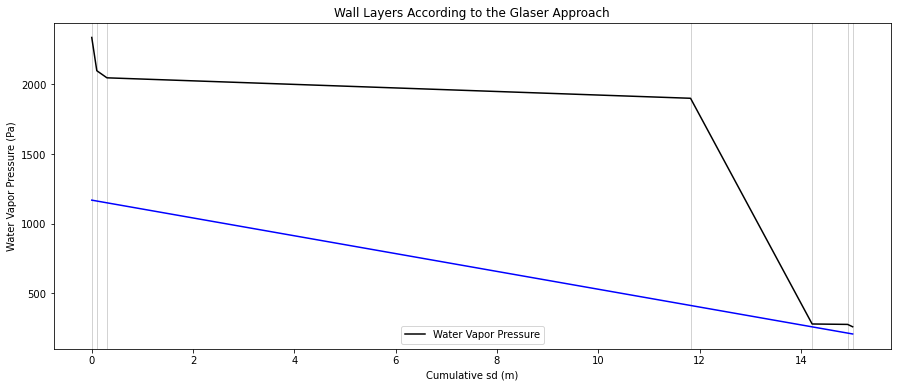

In [35]:
# Create the adjusted plot for water vapor pressure
plt.figure(figsize=(15, 6))

# Add vertical lines for each value in 'cumulative_sd'
for sd_value in layers_T_wVapor["cum_sd"]:
    plt.axvline(x=sd_value, color="lightgray", linestyle="-", linewidth=1)

plt.xlabel("Cumulative sd (m)")
plt.ylabel("Water Vapor Pressure (Pa)")
plt.plot(
    layers_T_wVapor["cum_sd"],
    layers_T_wVapor["WaterVaporPressure_Pa"],
    "-",
    label="Water Vapor Pressure",
    color="black",
)

internal_point = 0.5 * layers_T_wVapor.loc[0, "WaterVaporPressure_Pa"]
external_point = (
    0.8 * layers_T_wVapor.loc[len(layers_T_wVapor) - 1, "WaterVaporPressure_Pa"]
)

plt.plot(
    (
        layers_T_wVapor.loc[0, "cum_sd"],
        layers_T_wVapor.loc[len(layers_T_wVapor) - 1, "cum_sd"],
    ),
    (internal_point, external_point),
    color="blue",
)

plt.title("Wall Layers According to the Glaser Approach")
plt.legend()
plt.show()
